In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from time import time
from keras.layers import Dense, Input,Conv1D, MaxPooling1D, Flatten, Embedding, Reshape, UpSampling1D, LeakyReLU, ReLU, Average, Add
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import load_model
import keras.backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
P = np.array([
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
    [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
], dtype='int')

In [3]:
def awgn(x_input, reqSNR):
    sig_power = 1
    
    noise_power = np.sqrt(sig_power / (2*reqSNR))
    noise = noise_power * np.random.normal(size = x_input.shape)
    
    return x_input + noise

In [4]:
m = np.random.randint(2, size=(10**7, 12))
G= np.concatenate((P, np.eye(12, dtype="int")), axis=1)
x_train = np.dot(m, G) % 2
x_train = np.where(x_train > 0, -1, 1)
    
m = np.random.randint(2, size=(10**3, 12))
x_test = np.dot(m, G) % 2
x_test = np.where(x_test > 0, -1, 1)    

In [ ]:
Eb_No = 10**(3/10)
Es_No = Eb_No * (12/23)
x_train_noisy = awgn(x_train[:5*10**6], Es_No)
x_test_noisy = awgn(x_test[:5*10**2], Es_No)

Eb_No = 10**(8/10)
Es_No = Eb_No * (12/23)
x_train_noisy = np.vstack((x_train_noisy, awgn(x_train[5*10**6:], Es_No)))
x_test_noisy = np.vstack((x_test_noisy, awgn(x_test[5*10**2:], Es_No)))

masking = np.ones((10**7, 1))
masking[5*10**6:] = -1*masking[5*10**6:]
x_train = np.hstack((masking, x_train))
x_train_noisy = np.hstack((masking, x_train_noisy))

masking = np.ones((10**3, 1))
masking[5*10**2:] = -1*masking[5*10**2:]
x_test = np.hstack((masking, x_test))
x_test_noisy = np.hstack((masking, x_test_noisy))

In [ ]:
# model = Sequential()
input_layer = Input(shape=(24,))
line1_Dense1 = Dense(48, activation='elu')(input_layer)
line1_Dense2 = Dense(96, activation='elu')(line1_Dense1)         
line1_Dense3 = Dense(48, activation='elu')(line1_Dense2)
line1_output_layer = Dense(24, activation='tanh')(line1_Dense3)

line2_Dense1 = Dense(72, activation='elu')(input_layer)
line2_Dense2 = Dense(216, activation='elu')(line2_Dense1)         
line2_Dense3 = Dense(72, activation='elu')(line2_Dense2)
line2_output_layer = Dense(24, activation='tanh')(line2_Dense3)

line3_Dense1 = Dense(96, activation='elu')(input_layer)
line3_Dense2 = Dense(384, activation='elu')(line3_Dense1)         
line3_Dense3 = Dense(96, activation='elu')(line3_Dense2)
line3_output_layer = Dense(24, activation='tanh')(line3_Dense3)

line4_Dense1 = Dense(120, activation='elu')(input_layer)
line4_Dense2 = Dense(600, activation='elu')(line4_Dense1)         
line4_Dense3 = Dense(120, activation='elu')(line4_Dense2)
line4_output_layer = Dense(24, activation='tanh')(line4_Dense3)


line5_Dense1 = Dense(24, activation='elu')(input_layer)
line5_Dense2 = Dense(24, activation='elu')(line5_Dense1)         
line5_Dense3 = Dense(24, activation='elu')(line5_Dense2)
line5_output_layer = Dense(24, activation='tanh')(line5_Dense3)


# average_layer = Average()([line1_output_layer, line2_output_layer, line3_output_layer])
add_layer = Add()([line1_output_layer, line2_output_layer, line3_output_layer, line4_output_layer, line5_output_layer])
# average_layer = Average()([line1_Dense3, line2_Dense3, line3_Dense3])
output_layer = Dense(24, activation='linear')(add_layer)

model = Model(inputs = input_layer, outputs=output_layer)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [4]:
model = load_model('model_p5_24.h5')

In [ ]:
model.summary()

In [ ]:
model.fit(x_train_noisy, x_train, 
          epochs=100,
          batch_size=10000,
          shuffle=True,
          validation_data=(x_test_noisy, x_test))

6
high
output 0.0015
input 0.0205
x:  [ 1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1] 
n:  [0 0 0 0 1 1 1 0 0 0 1 1] 
decode: [1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1]


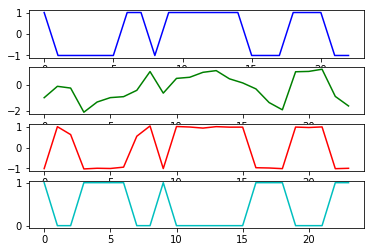

In [15]:
m = np.random.randint(2, size=(10**3, 12))
x_test = np.dot(m, G) % 2
x_test = np.where(x_test > 0, -1, 1)    

k = np.random.randint(11)
print(k)
Eb_No = 10**(k/10)
Es_No = Eb_No * (12/23)
x_test_noisy = awgn(x_test, Es_No)
if np.var(x_test_noisy) > 1.3:
    print('low')
    x_test_noisy = np.hstack((np.ones((10**3,1)), x_test_noisy))
else :
    print('high')
    x_test_noisy = np.hstack((-1*np.ones((10**3,1)), x_test_noisy))
    
decoded_imgs = model.predict(x_test_noisy)
  
decoded_imgs = np.reshape(decoded_imgs, (len(x_test), 24))

n = 25

            
for i in range(24, n):
    # display original
    
    plt.subplot(411)
    plt.plot(x_test[i].reshape(23), 'b')



    # display noisy
    
    plt.subplot(412)
    plt.plot(x_test_noisy[i].reshape(24), 'g')



    # display reconstruction

    plt.subplot(413)
    plt.plot(decoded_imgs[i].reshape(24), 'r')
    
    decoded_imgs = np.where(decoded_imgs < 0, 1, 0)     
    count = ((m+decoded_imgs[:,12:])%2).sum()
    print('output', count/(m.shape[0]*m.shape[1]))
    x_input = np.where(x_test_noisy < 0, 1, 0)
    count = ((m+x_input[:,12:])%2).sum()
    print('input', count/(m.shape[0]*m.shape[1]))
    
    plt.subplot(414)
    plt.plot(decoded_imgs[i].reshape(24), 'c')
    
    print("x: ", x_test[i], "\nn: ", m[i],"\ndecode:", decoded_imgs[i])

plt.show()



In [ ]:

model.save('model_p5_24.h5')

In [ ]:
model.load_weights('model_weight.h5')